# CSS5228 Final Project

In this notebook, we will start training our model.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from math import sqrt
import gc

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from xgboost.callback import EarlyStopping
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import cv

import optuna

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

from src.utils import highlight_top, save_fig


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df_train = pd.read_csv("clean_data/train_preproc.csv", index_col=0)
df_test = pd.read_csv("clean_data/test_preproc.csv", index_col=0)
df_submission = pd.read_csv("raw_data/example-submission.csv")

In [4]:
X = df_train.drop("price", axis=1)
y = df_train["price"]
df_test = df_test.loc[:, X.columns]

In [5]:
sns.set_theme(style="ticks")
sns.set_context("paper", rc={"xtick.labelsize":15,
                             "ytick.labelsize":15,
                             "axes.titlesize":20,
                             "axes.labelsize":15})
default_col = '#4c72b0'
highlight_col = '#c44d52'

img_dir = Path("images/")

# 1. Baseline Performance

- We will start off with ensemble tree methods since it doesn't require standardization and performs relatively well.
- We will also be able to leverage on the feature importance function to have a sense of how each feature is performing

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

print("Size of training set: {}".format(len(X_train)))
print("Size of test: {}".format(len(X_valid)))
print(len(X_valid), len(y_valid))

Size of training set: 13916
Size of test: 3479
3479 3479


In [7]:
model_selector = {"LGBM": LGBMRegressor(), 
                  "GradientBoost":GradientBoostingRegressor(), 
                  "XGBoost": XGBRegressor(),
                  "Random Forest": RandomForestRegressor(),
                  "CatBoost": CatBoostRegressor()}

In [8]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

In [9]:
for model_name in model_selector:
    print("=============")
    print("Model: {}".format(model_name))
    print("=============")
    fold_score = []
    
    for fold, (train_idx, val_idx) in enumerate(k_fold.split(X, y)):
            
        print("\nFold {}".format(fold+1))
        X_train, y_train = X.iloc[train_idx,:], y[train_idx]
        X_val, y_val = X.iloc[val_idx,:], y[val_idx]
        print("Train shape: {}, {}, Valid shape: {}, {}".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))
        
        model = model_selector[model_name]
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        
        rmse_score = mean_squared_error(y_val, y_pred, squared=False)
        fold_score.append(rmse_score)
        print("Validation RMSE = {:.4f}".format(rmse_score))
    print("================================")
    print("RMSE = {}".format(np.mean(fold_score)))

Model: LGBM

Fold 1
Train shape: (13916, 21), (13916,), Valid shape: (3479, 21), (3479,)
Validation RMSE = 1835064.6718

Fold 2
Train shape: (13916, 21), (13916,), Valid shape: (3479, 21), (3479,)
Validation RMSE = 1416718.3083

Fold 3
Train shape: (13916, 21), (13916,), Valid shape: (3479, 21), (3479,)
Validation RMSE = 2541281.5170

Fold 4
Train shape: (13916, 21), (13916,), Valid shape: (3479, 21), (3479,)
Validation RMSE = 1396179.4089

Fold 5
Train shape: (13916, 21), (13916,), Valid shape: (3479, 21), (3479,)
Validation RMSE = 2738854.2090
RMSE = 1985619.6229717438
Model: GradientBoost

Fold 1
Train shape: (13916, 21), (13916,), Valid shape: (3479, 21), (3479,)
Validation RMSE = 2148280.3490

Fold 2
Train shape: (13916, 21), (13916,), Valid shape: (3479, 21), (3479,)
Validation RMSE = 1548948.5402

Fold 3
Train shape: (13916, 21), (13916,), Valid shape: (3479, 21), (3479,)
Validation RMSE = 2808953.3287

Fold 4
Train shape: (13916, 21), (13916,), Valid shape: (3479, 21), (3479,)


# 2. Hyperparameter Tuning

In [9]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_float("learning_rate", 0.005, 0.2)
    param['depth'] = trial.suggest_int('depth', 6, 15, step=1)
    param['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg', 1.0, 5.5)
    param['min_child_samples'] = trial.suggest_int('min_child_samples', 5, 15, step=1)
    param['grow_policy'] = 'Depthwise'
    param['iterations'] = 500
    param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    param['od_type'] = 'iter'
    param['od_wait'] = 20
    param['random_state'] = 42
    param['logging_level'] = 'Silent'
    
    cv_scores = np.empty(5)
    for fold, (train_idx, val_idx) in enumerate(k_fold.split(X, y)):
        X_train, y_train = X.iloc[train_idx,:], y[train_idx]
        X_val, y_val = X.iloc[val_idx,:], y[val_idx]
        
        regressor = CatBoostRegressor(**param)

        regressor.fit(X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    early_stopping_rounds=100)
        
        y_pred = regressor.predict(X_valid)
        loss = mean_squared_error(y_valid, y_pred, squared=False)
        cv_scores[fold] = loss
    
    return np.mean(cv_scores)

In [10]:
# for each iteration, print the best trial result
%%time
study = optuna.create_study(direction="minimize", study_name="CatboostRegressor")
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2022-09-30 12:40:46,374] A new study created in memory with name: CatboostRegressor
[I 2022-09-30 12:42:12,407] Trial 7 finished with value: 770736.4571610461 and parameters: {'learning_rate': 0.07735434220121781, 'depth': 6, 'l2_leaf_reg': 5.3237713349556195, 'min_child_samples': 11}. Best is trial 7 with value: 770736.4571610461.
[I 2022-09-30 12:42:31,973] Trial 5 finished with value: 610253.7468112527 and parameters: {'learning_rate': 0.1043212312037481, 'depth': 7, 'l2_leaf_reg': 4.941103989526203, 'min_child_samples': 11}. Best is trial 5 with value: 610253.7468112527.
[I 2022-09-30 12:42:58,331] Trial 6 finished with value: 770122.6605366545 and parameters: {'learning_rate': 0.05160353488712986, 'depth': 7, 'l2_leaf_reg': 5.344939579567149, 'min_child_samples': 5}. Best is trial 5 with value: 610253.7468112527.
[I 2022-09-30 12:43:54,768] Trial 11 finished with value: 732483.7451911866 and parameters: {'learning_rate': 0.039584646675287403, 'depth': 9, 'l2_leaf_reg': 4.956500

Wall time: 1h 59min 56s


In [11]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 411078.41150
	Best params:
		learning_rate: 0.1173474866155376
		depth: 15
		l2_leaf_reg: 2.985006043098707
		min_child_samples: 12


In [37]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(width=1200, height=500)
plt.tight_layout()
fig.show()

<Figure size 432x288 with 0 Axes>

In [34]:
fig = optuna.visualization.plot_contour(study, params=['learning_rate',
                                                 'min_child_samples',
                                                 'depth',
                                                 'l2_leaf_reg'])
fig.update_layout(width=1200, height=1000)
plt.tight_layout()
fig.show()

Saving figure hpo_contour_plot


<Figure size 432x288 with 0 Axes>

In [36]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(width=800, height=500)
plt.tight_layout()
fig.show()

Saving figure hpo_importance


<Figure size 432x288 with 0 Axes>

# 3. Model Training with best params

In [38]:
study.best_params

{'learning_rate': 0.1173474866155376,
 'depth': 15,
 'l2_leaf_reg': 2.985006043098707,
 'min_child_samples': 12}

In [39]:
fold_score = []
feat_importance = pd.DataFrame(index = X.columns)
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

for fold, (train_idx, val_idx) in enumerate(k_fold.split(X, y)):
            
    print("\nFold {}".format(fold+1))
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_val, y_val = X.iloc[val_idx,:], y[val_idx]
    print("Train shape: {}, {}, Valid shape: {}, {}".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))
    
    model = CatBoostRegressor(learning_rate=0.1173474866155376,
                              depth=15,
                              l2_leaf_reg=2.985006043098707,
                              min_child_samples=12)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    feat_importance["Importance_Fold"+str(fold)] = model.feature_importances_
    
    rmse_score = mean_squared_error(y_val, y_pred, squared=False)
    fold_score.append(rmse_score)
    print("Validation RMSE = {:.4f}".format(rmse_score))
print("================================")
print("RMSE = {}".format(np.mean(fold_score)))


Fold 1
Train shape: (13916, 21), (13916,), Valid shape: (3479, 21), (3479,)
0:	learn: 4503483.4522297	total: 1.22s	remaining: 20m 22s
1:	learn: 4183295.2071462	total: 2.08s	remaining: 17m 20s
2:	learn: 3887425.3780111	total: 2.86s	remaining: 15m 50s
3:	learn: 3640833.1276991	total: 3.69s	remaining: 15m 20s
4:	learn: 3414273.8939328	total: 4.44s	remaining: 14m 43s
5:	learn: 3215623.4203199	total: 5.19s	remaining: 14m 19s
6:	learn: 3050314.1539209	total: 5.91s	remaining: 13m 58s
7:	learn: 2876218.8616303	total: 6.63s	remaining: 13m 42s
8:	learn: 2709616.4519958	total: 7.32s	remaining: 13m 25s
9:	learn: 2589653.0170612	total: 8.07s	remaining: 13m 18s
10:	learn: 2461760.8768898	total: 8.84s	remaining: 13m 14s
11:	learn: 2349605.9890025	total: 9.54s	remaining: 13m 5s
12:	learn: 2242501.0163609	total: 10.3s	remaining: 13m 1s
13:	learn: 2147190.6621607	total: 11.1s	remaining: 13m
14:	learn: 2048849.5266431	total: 11.8s	remaining: 12m 54s
15:	learn: 1970563.0326017	total: 12.5s	remaining: 12m

In [40]:
average_importance = np.mean(feat_importance, axis=1)
average_importance = average_importance.reset_index()
average_importance = average_importance.rename(columns={0:"mean_importance"})
average_importance["mean_importance"] = round(average_importance["mean_importance"], 5)
average_importance = average_importance.sort_values(by=["mean_importance"], ascending=False)

Saving figure feature_importance


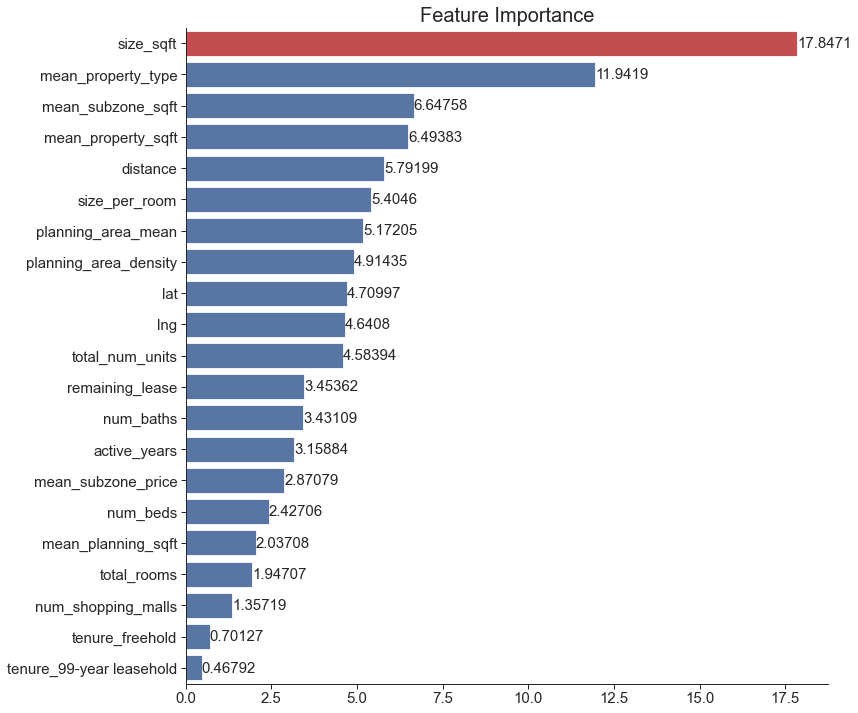

In [41]:
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(x="mean_importance", y="index", data=average_importance, color=default_col)
ax.bar_label(ax.containers[0], fontsize=15)
sns.despine()
highlight_top(ax, "horizontal", highlight_col)
plt.title("Feature Importance")
plt.xlabel("")
plt.ylabel("")
save_fig("feature_importance", img_dir)
plt.show()


In [42]:
pred = model.predict(df_test)

# Submission

In [43]:
df_submission["Predicted"] = pred

In [44]:
df_submission.head()

,Id,Predicted
0,0,1.133261e+06
1,1,1.542703e+06
2,2,1.106124e+06
3,3,6.723281e+05
4,4,4.896687e+05


In [45]:
df_submission.to_csv("submissions/catboost_submission_30sep.csv", index=0)